In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
import sncosmo
from scipy import stats
from nested_pandas import read_parquet
from joblib import Parallel, delayed

from tdastro.opsim.ztf_opsim import ZTFOpsim
from tdastro.astro_utils.passbands import PassbandGroup
from tdastro.astro_utils.pzflow_node import PZFlowNode
from tdastro.astro_utils.snia_utils import (
    DistModFromRedshift,
    HostmassX1Func,
    X0FromDistMod,
    num_snia_per_redshift_bin,
)
from tdastro.math_nodes.scipy_random import SamplePDF
from tdastro.math_nodes.np_random import NumpyRandomFunc
from tdastro.simulate import simulate_lightcurves
from tdastro.sources.sncomso_models import SncosmoWrapperModel
from tdastro.sources.snia_host import SNIaHost
from tdastro.utils.plotting import plot_lightcurves
from tdastro.math_nodes.ra_dec_sampler import OpSimUniformRADECSampler
from tdastro.astro_utils.dustmap import DustmapWrapper,SFDMap
from tdastro.effects.extinction import ExtinctionEffect
from tdastro.astro_utils.mag_flux import mag2flux

from tdastro import _TDASTRO_BASE_DATA_DIR

from tdastro.validation.lcfit import fit_single_lc

In [3]:
globalhostdata = pd.read_csv('ztfsniadr2/tables/globalhost_data.csv')
localhostdata = pd.read_csv('ztfsniadr2/tables/localhost_data.csv')
sndata = pd.read_csv('ztfsniadr2/tables/snia_data.csv')
data = pd.merge(sndata,globalhostdata,on='ztfname')

In [4]:
lcdata = read_parquet('data/ztfsniadr2.parquet')

In [5]:
%%time
# Load the OpSim data.
opsim_db = ZTFOpsim.from_db("data/ztf_metadata_latest.db")
# obs_log = pd.read_parquet('ztfsniadr2/tables/observing_logs.parquet')
# obs_log = obs_log.drop_duplicates("expid")
# obs_log["filter"] = obs_log.apply(lambda row: row["band"][-1],axis=1)
# obs_log = pd.merge(obs_log, opsim_db.table[["expid","filter","exptime","fwhm","obsmjd","scibckgnd","ra","dec"]],on=["filter","expid"])
# obs_log["zp_nJy"] = mag2flux(obs_log["zp"].values)
# colmap = {"ra":"ra",
#           "dec":"dec",
#           "time":"mjd",
#           "zp":"zp_nJy",
#           "filter":"filter",
#           "sky":"scibckgnd"}
# opsim_db = ZTFOpsim(obs_log,colmap=colmap)
t_min, t_max = opsim_db.time_bounds()
print(f"Loaded OpSim with {len(opsim_db)} rows and times [{t_min}, {t_max}]")

#Load the passband data for the griz filters only.
# passband_group = PassbandGroup(preset="LSST", filters_to_load=["g", "r", "i"], 
#                                units="nm", trim_quantile=0.001, delta_wave=1)
passband_group = PassbandGroup(preset="ZTF", filters_to_load=["g", "r", "i"])
print(f"Loaded Passbands: {passband_group}")

/Users/mi/Work/tdastro/tdastro/src/tdastro/opsim/ztf_opsim.py:171: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.table = self.table.replace("", np.nan)
2025-05-06 00:27:48,533 - INFO - Loading passbands from preset ZTF


Loaded OpSim with 864838 rows and times [58197.12385416667, 60247.54819699074]
Loaded Passbands: PassbandGroup containing 3 passbands: ZTF_g, ZTF_r, ZTF_i
CPU times: user 3.44 s, sys: 230 ms, total: 3.67 s
Wall time: 3.69 s


In [6]:
# Load the Flow model into a PZFlow node. This gives access to all of the outputs of the
# flow model as attributes of the PZFlowNode.
pz_node = PZFlowNode.from_file("data/ztfsniadr2_host_sn_pzflow.pkl",  # filename
    node_label="pznode",
)
radec_node = OpSimUniformRADECSampler(opsim_db, radius=2.735, node_label="radec")

# Create a model for the host of the SNIa. The attributes will be sampled via
# the PZFlowNode's model. So each hos instantiation will have its own properties.
# Note: This requires the user to know the output names from the underlying flow model.

zmin = 0.001
zmax = 0.2
H0 = 70.0
Omega_m = 0.3
nsn, z = num_snia_per_redshift_bin(zmin, zmax, 100, H0=H0, Omega_m=Omega_m)
zpdf = interp1d(z, nsn, bounds_error=False, fill_value=0)

host = SNIaHost(
    ra = radec_node.ra,
    dec = radec_node.dec,
    hostmass=pz_node.mass,
    redshift=SamplePDF(zpdf),
    node_label="host",
)

INFO:2025-05-06 00:27:48,600:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-05-06 00:27:48,600 - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-05-06 00:27:48,602:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/mi/anaconda3/envs/tdastro/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
2025-05-06 00:27:48,602 - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Crypt

In [7]:
distmod_func = DistModFromRedshift(host.redshift, H0=73.0, Omega_m=0.3)
# x1_func = HostmassX1Func(host.hostmass)
# c_func = NumpyRandomFunc("normal", loc=0, scale=0.02)
m_abs_func = NumpyRandomFunc("normal", loc=-19.3, scale=0.1)
x0_func = X0FromDistMod(
    distmod=distmod_func,
    x1=NumpyRandomFunc("uniform",low=-5.,high=5.),
    c=NumpyRandomFunc("uniform",low=-0.5,high=0.5),
    alpha=0.14,
    beta=3.1,
    m_abs=m_abs_func,
    node_label="x0_func",
)

sncosmo_modelname = "salt3"
source = SncosmoWrapperModel(
    sncosmo_modelname,
    t0=NumpyRandomFunc("uniform", low=t_min, high=t_max),
    x0=x0_func,
    x1=x0_func.x1, #x1_func,
    c=x0_func.c, #c_func,
    ra=NumpyRandomFunc("normal", loc=host.ra, scale=0.01),
    dec=NumpyRandomFunc("normal", loc=host.dec, scale=0.01),
    redshift=host.redshift,
    node_label="source",
)
    
mwextinction = SFDMap(
    ra=source.ra,
    dec=source.dec,
    node_label="mwext",
)

# Create an extinction effect using the EBVs from that dust map.
ext_effect = ExtinctionEffect(extinction_model="F99", ebv=mwextinction, Rv=3.1)
source.add_effect(ext_effect)


2025-05-06 00:27:49,947 - INFO - SFD dust map data files not found.
Attempting to download from: ('https://github.com/kbarbary/sfddata/archive/master.tar.gz',)
to the directory /Users/mi/Work/tdastro/tdastro/data/dustmaps/sfdmap2


In [8]:
%%time
nsntotal, _ = num_snia_per_redshift_bin(zmin, zmax, 1, H0=H0, Omega_m=Omega_m, solid_angle=9.136)
print(nsntotal)
lightcurves = simulate_lightcurves(source, int(nsntotal), opsim_db, passband_group)
lightcurves

[47697.87880084]


<timed exec>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


CPU times: user 4min 51s, sys: 1min 23s, total: 6min 14s
Wall time: 6min 12s


id          ra        dec  nobs         z  \
0          0  309.778513 -16.640589   632  0.163613   
1          1  348.861925 -29.164209    17  0.155908   
...      ...         ...        ...   ...       ...   
47695  47695  243.865119  13.385414  1286  0.197130   
47696  47696  283.521301  13.819981  1937  0.197122   

                                                  params  \
0      {'radec.ra': 309.78108592412724, 'radec.dec': ...   
1      {'radec.ra': 348.8669136280953, 'radec.dec': -...   
...                                                  ...   
47695  {'radec.ra': 243.8545731701698, 'radec.dec': 1...   
47696  {'radec.ra': 283.52220323921597, 'radec.dec': ...   

                                              lightcurve  
0      [{mjd: 58263.459778, filter: 'g', flux: 4370.4...  
1      [{mjd: 59146.225694, filter: 'r', flux: NaN, f...  
...                                                  ...  
47695  [{mjd: 58198.418229, filter: 'r', flux: 3872.4...  
47696  [{mjd: 58204.507674, filter: 'g', flux: 3116.0...  

[47697 rows x 7 columns]

In [9]:
lightcurves['params'][0].keys()

dict_keys(['radec.ra', 'radec.dec', 'host.ra', 'host.dec', 'host.redshift', 'host.t0', 'host.distance', 'host.hostmass', 'SamplePDF:_rvs_4.function_node_result', 'pznode.mass', 'pznode.restframe_gz', 'pznode.redshift', 'pznode.x1', 'pznode.c', 'NumpyRandomFunc:normal_1.loc', 'NumpyRandomFunc:normal_1.scale', 'NumpyRandomFunc:normal_1.function_node_result', 'source.ra', 'source.dec', 'source.redshift', 'source.t0', 'source.distance', 'source.x0', 'source.x1', 'source.c', 'source.Rv', 'source.ebv', 'NumpyRandomFunc:normal_6.loc', 'NumpyRandomFunc:normal_6.scale', 'NumpyRandomFunc:normal_6.function_node_result', 'NumpyRandomFunc:uniform_7.low', 'NumpyRandomFunc:uniform_7.high', 'NumpyRandomFunc:uniform_7.function_node_result', 'DistModFromRedshift:_distmod_from_redshift_9.redshift', 'DistModFromRedshift:_distmod_from_redshift_9.function_node_result', 'x0_func.distmod', 'x0_func.x1', 'x0_func.c', 'x0_func.alpha', 'x0_func.beta', 'x0_func.m_abs', 'x0_func.function_node_result', 'NumpyRandom

In [10]:
lightcurves.lightcurve.isna().sum()

80

In [11]:
#apply detection and spec efficiency
lightcurves = lightcurves.dropna(subset=['lightcurve'])
print("Before applying detection: nsn=", len(lightcurves))
lightcurves['lightcurve.snr'] = lightcurves['lightcurve.flux']/lightcurves['lightcurve.fluxerr']
lightcurves_after_detection = lightcurves.query('lightcurve.snr > 5').dropna(subset=['lightcurve'])
print("After applying detection: nsn=", len(lightcurves_after_detection))
maglim = mag2flux(18.5)
idx = lightcurves_after_detection.query(f'lightcurve.flux > {maglim}').dropna(subset=['lightcurve']).index
lightcurves_after_spec_selection = lightcurves_after_detection.loc[idx]
print("After spectroscopic selection: nsn=", len(lightcurves_after_spec_selection))

Before applying detection: nsn= 47617


/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/nested_pandas/nestedframe/core.py:407: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().__setitem__(nested, new_nested_series)


After applying detection: nsn= 16760
After spectroscopic selection: nsn= 3086


/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/nested_pandas/nestedframe/core.py:645: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  answer = super().eval(expr, **kwargs)
/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/nested_pandas/nestedframe/core.py:645: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  answer = super().eval(expr, **kwargs)


In [12]:
#apply some data quality cut for fitting
lightcurves_after_nobs_cut = lightcurves_after_spec_selection[np.array(lightcurves_after_spec_selection.reduce(len, "lightcurve.mjd") > 7)]
print("After nobs cut: nsn=", len(lightcurves_after_nobs_cut))

After nobs cut: nsn= 2731


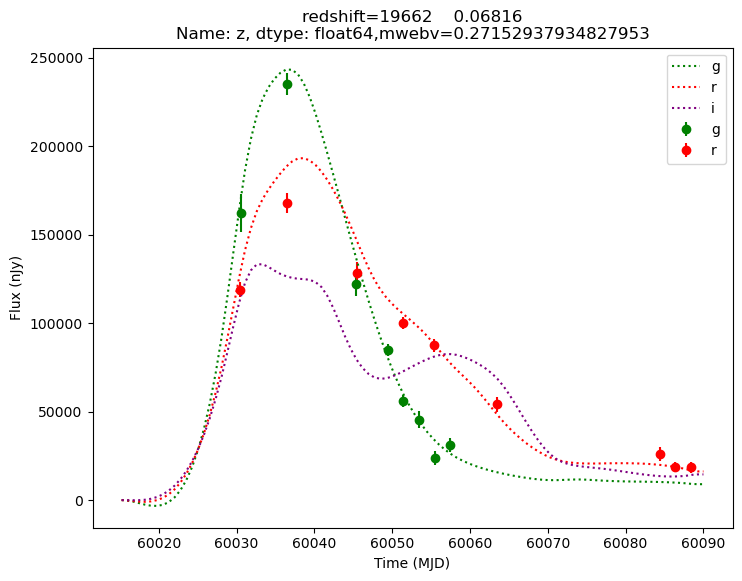

In [13]:
random_ids = lightcurves_after_nobs_cut.id.sample(1).values
colormap = {'g':'g',
            'r':'r',
            'i':'purple',}

for random_id in random_ids:
    # Extract the row for this object.
    lc = lightcurves.loc[lightcurves.id==random_id]
    lc = lightcurves_after_nobs_cut.loc[lightcurves_after_nobs_cut.id==random_id]
    
    if lc["nobs"].values[0] > 0:
        # Unpack the nested columns (filters, mjd, flux, and flux error).
        lc_filters = np.asarray(lc["lightcurve.filter"], dtype=str)
        lc_mjd = np.asarray(lc["lightcurve.mjd"], dtype=float)
        lc_flux = np.asarray(lc["lightcurve.flux"], dtype=float)
        lc_fluxerr = np.asarray(lc["lightcurve.fluxerr"], dtype=float)

        lc_mag = -2.5*np.log10(lc_flux) + 31.4
        lc_magerr = np.absolute(1.086*lc_fluxerr/lc_flux)
        
        plot_lightcurves(
            fluxes=lc_flux,
            times=lc_mjd,
            fluxerrs=lc_fluxerr,
            filters=lc_filters,
            colormap=colormap,
        )
        plt.ylabel('Flux (nJy)')
        plt.title(f"redshift={lc['z']},mwebv={lc['params'].values[0]['mwext.ebv']}")

        model = sncosmo.Model(source=sncosmo_modelname,
                      effects=[sncosmo.F99Dust()],
                      effect_names=['mw'],
                      effect_frames=['obs'])
        pardict = {}
        for p in ['x0','x1','c','t0']:
            pardict[p] = lc['params'].values[0][f'source.{p}']
        pardict['mwebv'] = lc['params'].values[0]['mwext.ebv']
        pardict['z'] = lc['z'].values[0]
        model.update(pardict)
        t = np.linspace(-20,50,100)
        obstime = t*(1+pardict['z'])+pardict['t0']
        for b in 'gri':
            plt.plot(obstime,model.bandflux('lsst'+b,obstime,zp=31.4,zpsys='ab'),label=b,ls=':',color=colormap[b])
        plt.legend()
        plt.show()

        # plot_lightcurves(
        #     fluxes=lc_mag,
        #     times=lc_mjd,
        #     fluxerrs=lc_magerr,
        #     filters=lc_filters,
        # )
        # plt.ylabel('Mag')
        # plt.ylim(plt.ylim()[::-1])
        plt.show()

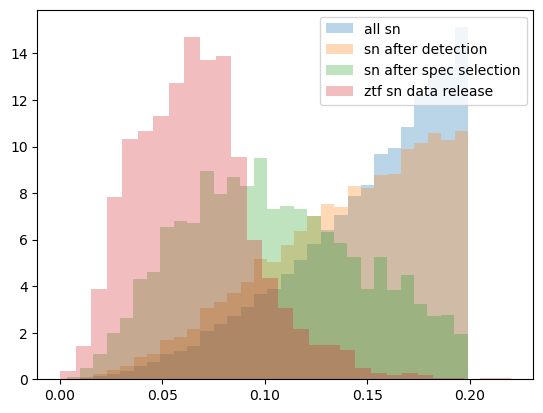

In [14]:
plt.hist(lightcurves['z'],bins=30,alpha=0.3,density=True,label='all sn')
plt.hist(lightcurves_after_detection['z'],bins=30,alpha=0.3,density=True,label='sn after detection')
plt.hist(lightcurves_after_spec_selection['z'],bins=30,alpha=0.3,density=True,label='sn after spec selection')
plt.hist(data.redshift,bins=np.linspace(0,0.22,30),alpha=0.3,density=True,label='ztf sn data release')
plt.legend()
plt.show()

/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/nested_pandas/nestedframe/core.py:645: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  answer = super().eval(expr, **kwargs)


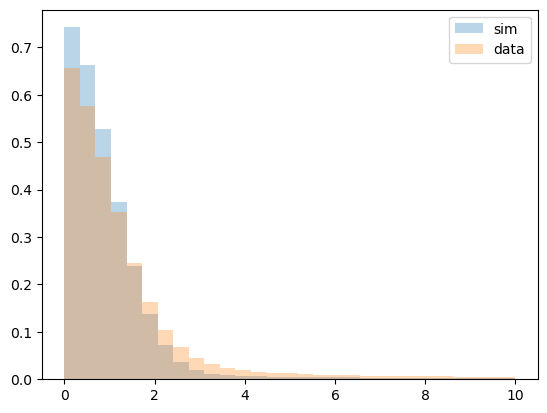

In [15]:
lc_to_plot = lightcurves.loc[lightcurves_after_detection.index]
bins = np.linspace(0,10,30)
plt.hist(lc_to_plot['lightcurve.snr'],bins=bins,alpha=0.3,density=True,label='sim')
lcdata_plot = lcdata.query('lc.flux_err > 0').dropna(subset='lc')
lcdata_plot['lc.snr'] = lcdata_plot['lc.flux']/lcdata_plot['lc.flux_err']
plt.hist(lcdata_plot['lc.snr'],bins=bins,alpha=0.3,density=True,label='data')
plt.legend()
plt.show()

/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/nested_pandas/nestedframe/core.py:645: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  answer = super().eval(expr, **kwargs)
/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/nested_pandas/nestedframe/core.py:645: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  answer = super().eval(expr, **kwargs)


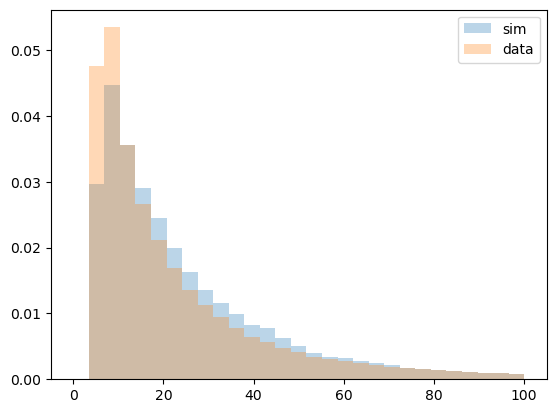

In [16]:
lc_to_plot = lightcurves_after_detection.loc[lightcurves_after_spec_selection.index]
bins = np.linspace(0,100,30)
plt.hist(lc_to_plot['lightcurve.snr'],bins=bins,alpha=0.3,density=True,label='sim')
lcdata = lcdata.query('lc.flux_err > 0').dropna(subset='lc')
lcdata['lc.snr'] = lcdata['lc.flux']/lcdata['lc.flux_err']
lcdata_plot = lcdata.query('lc.snr > 5').dropna(subset='lc')
plt.hist(lcdata_plot['lc.snr'],bins=bins,alpha=0.3,density=True,label='data')
plt.legend()
plt.show()

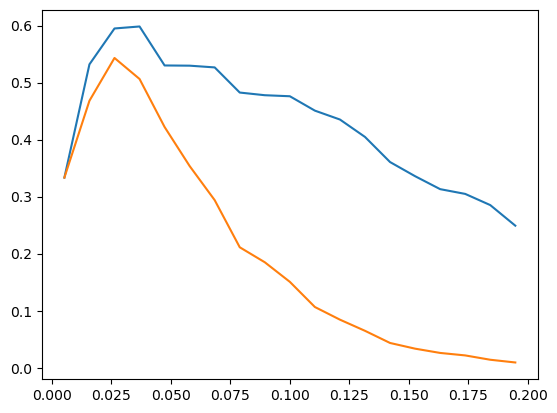

In [17]:
bins = np.linspace(0,0.2,20)
zbefore,bin_edges,_ = stats.binned_statistic(lightcurves['z'],np.ones(len(lightcurves)), statistic='sum', bins=bins)
zafter,bin_edges,_ =  stats.binned_statistic(lightcurves_after_detection['z'], np.ones(len(lightcurves_after_detection)), statistic='sum', bins=bins)
zafter_spec,bin_edges,_ =  stats.binned_statistic(lightcurves_after_spec_selection['z'], np.ones(len(lightcurves_after_spec_selection)), statistic='sum', bins=bins)
plt.plot((bin_edges[:-1] + bin_edges[1:])/2.,zafter/zbefore)
plt.plot((bin_edges[:-1] + bin_edges[1:])/2.,zafter_spec/zbefore)

In [18]:
sim_all_x1 = [lightcurves.loc[i]['params']['source.x1'] for i in lightcurves.index]
sim_all_c = [lightcurves.loc[i]['params']['source.c'] for i in lightcurves.index]

In [19]:
sim_x1 = [lightcurves_after_nobs_cut.loc[i]['params']['source.x1'] for i in lightcurves_after_nobs_cut.index]
sim_c = [lightcurves_after_nobs_cut.loc[i]['params']['source.c'] for i in lightcurves_after_nobs_cut.index]

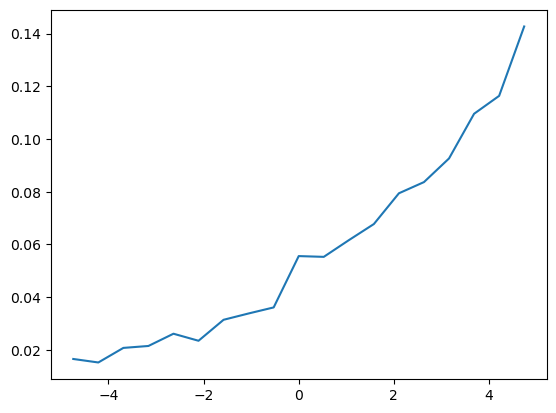

In [20]:
bins = np.linspace(-5,5,20)
x1before,bin_edges,_ = stats.binned_statistic(sim_all_x1,np.ones(len(lightcurves)), statistic='sum', bins=bins)
x1after,bin_edges,_ =  stats.binned_statistic(sim_x1, np.ones(len(lightcurves_after_nobs_cut)), statistic='sum', bins=bins)
plt.plot((bin_edges[:-1] + bin_edges[1:])/2.,x1after/x1before)

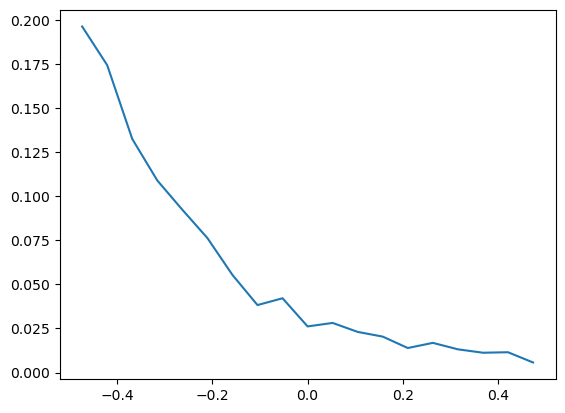

In [21]:
bins = np.linspace(-0.5,0.5,20)
cbefore,bin_edges,_ = stats.binned_statistic(sim_all_c,np.ones(len(lightcurves)), statistic='sum', bins=bins)
cafter,bin_edges,_ =  stats.binned_statistic(sim_c, np.ones(len(lightcurves_after_nobs_cut)), statistic='sum', bins=bins)
plt.plot((bin_edges[:-1] + bin_edges[1:])/2.,cafter/cbefore)

In [22]:
res = fit_single_lc(lightcurves.loc[0])
res

2025-05-06 00:34:44,807 - INFO - fitting 0, z=0.16361329946484987, mwebv=0.057044861855487454.


id    0
dtype: int64

In [23]:
lc_to_fit = lightcurves_after_nobs_cut.iloc[0:]

In [24]:
# %%time
# result_df0 = lc_to_fit.apply(fit_single_lc,axis=1)

In [25]:
%%time
results = Parallel(n_jobs=10)(delayed(fit_single_lc)(row) for _index, row in lc_to_fit.iterrows())
result_df = pd.DataFrame(results)

/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/mi/anaconda3/envs/tdastro/lib/p

CPU times: user 3.29 s, sys: 739 ms, total: 4.03 s
Wall time: 34.3 s


/Users/mi/anaconda3/envs/tdastro/lib/python3.11/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


In [26]:
result_df = result_df.set_index('id')

In [27]:
result_df.dropna()

,success,ncall,chisq,ndof,z,z_err,t0,t0_err,x0,x0_err,...,c_x0_cov,c_x1_cov,c_c_cov,c_mwebv_cov,mwebv_z_cov,mwebv_t0_cov,mwebv_x0_cov,mwebv_x1_cov,mwebv_c_cov,mwebv_mwebv_cov
id,,,,,,,,,,,,,,,,,,,,,
47.0,1.0,150.0,17.422426,10.0,0.099781,0.0,59975.162405,0.157537,0.002404,0.000031,...,-2.222098e-07,0.001013,0.000192,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65.0,1.0,228.0,8.442891,13.0,0.168927,0.0,59399.889619,1.082484,0.000775,0.000019,...,-1.959469e-07,-0.002134,0.000676,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47639.0,1.0,110.0,14.237919,18.0,0.125006,0.0,58710.286940,0.129875,0.001140,0.000015,...,-5.760940e-08,0.000243,0.000344,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47687.0,1.0,124.0,23.954021,26.0,0.163827,0.0,59163.742044,0.227993,0.000805,0.000013,...,-4.418434e-08,0.000588,0.000301,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/var/folders/zs/zxl3t6ks12zg2l3dp9qn1rkr0000gn/T/ipykernel_12458/1529270308.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(result_df[idx].chisq/result_df[idx].ndof,bins=np.linspace(0,10,20))
/var/folders/zs/zxl3t6ks12zg2l3dp9qn1rkr0000gn/T/ipykernel_12458/1529270308.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(result_df[idx].chisq/result_df[idx].ndof,bins=np.linspace(0,10,20))


Text(0.5, 1.0, 'reduced chisq')

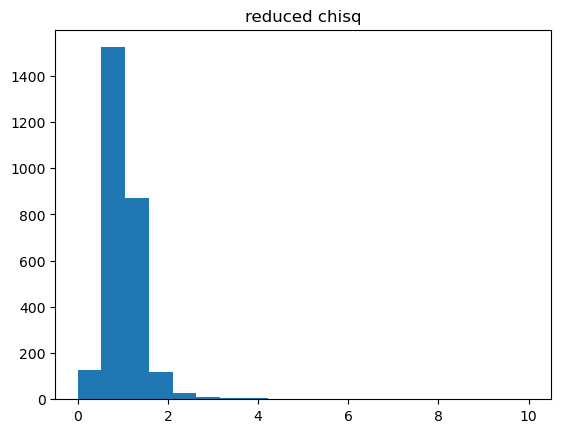

In [28]:
idx = result_df.ndof > 0
result_df = result_df[idx]
plt.hist(result_df[idx].chisq/result_df[idx].ndof,bins=np.linspace(0,10,20))
plt.title('reduced chisq')

Text(0.5, 1.0, 'x1-sim_x1')

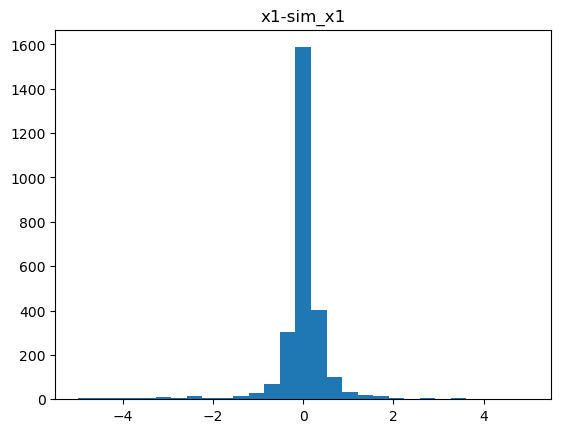

In [29]:
x1 = result_df['x1']
sim_x1 = [lc_to_fit.loc[i]['params']['source.x1'] for i in result_df.index]
plt.hist(x1-sim_x1,bins=np.linspace(-5,5,30))
plt.title('x1-sim_x1')

Text(0.5, 1.0, 'c-sim_c')

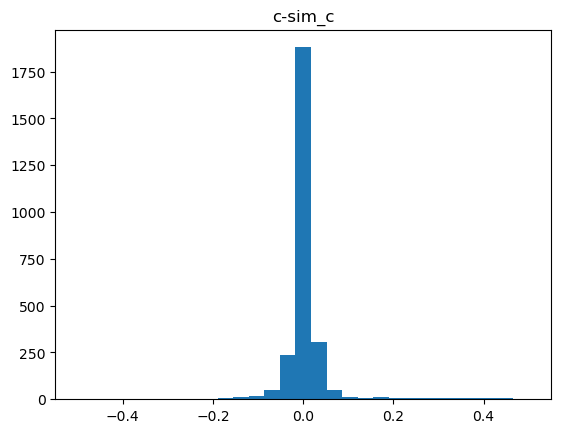

In [30]:
c = result_df['c']
sim_c = [lc_to_fit.loc[i]['params']['source.c'] for i in result_df.index]
plt.hist(c-sim_c,bins=np.linspace(-0.5,0.5,30))
plt.title('c-sim_c')

Text(0.5, 1.0, 'x0-sim_x0')

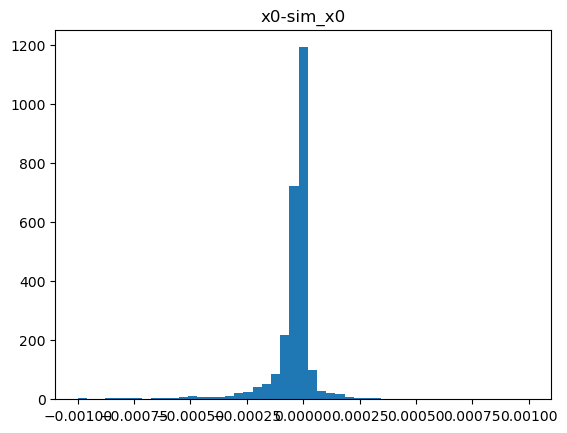

In [31]:
x0 = result_df['x0']
sim_x0 = [lc_to_fit.loc[i]['params']['source.x0'] for i in result_df.index]
plt.hist(x0-sim_x0,bins=np.linspace(-1.e-3,1.e-3))
plt.title('x0-sim_x0')

Text(0.5, 1.0, 'log(x0)-log(sim_x0)')

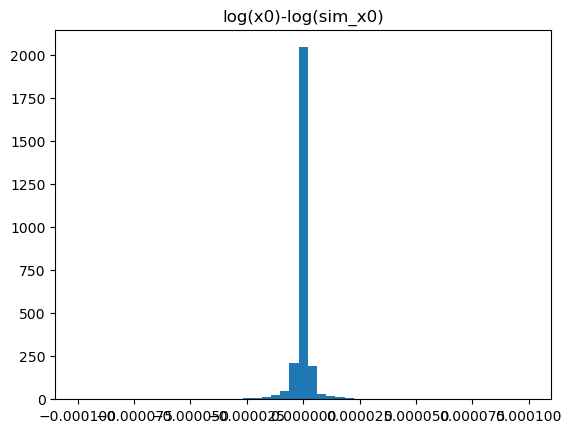

In [32]:
x0 = result_df['t0']
sim_x0 = [lc_to_fit.loc[i]['params']['source.t0'] for i in result_df.index]
plt.hist(np.log10(x0/sim_x0),bins=np.linspace(-1.e-4,1e-4))
plt.title('log(x0)-log(sim_x0)')

Text(0.5, 1.0, 'x1')

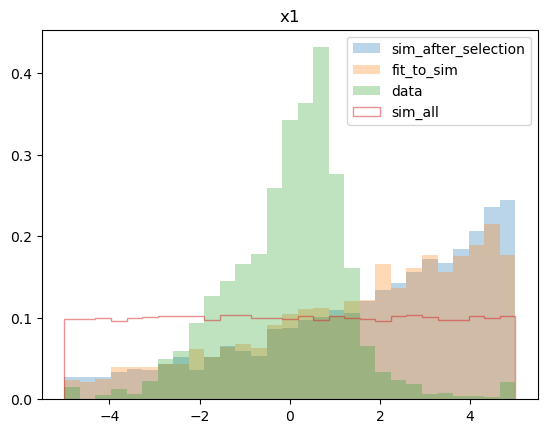

In [33]:
bins=np.linspace(-5,5,30)
plt.hist(sim_x1,bins=bins,alpha=0.3,density=True,label='sim_after_selection')
plt.hist(x1,bins=bins,alpha=0.3,density=True,label='fit_to_sim')
plt.hist(data.x1,bins=bins,alpha=0.3,density=True,label='data')
plt.hist(sim_all_x1,bins=bins,alpha=0.5,density=True,label='sim_all',histtype='step')
plt.legend()
plt.title('x1')

Text(0.5, 1.0, 'c')

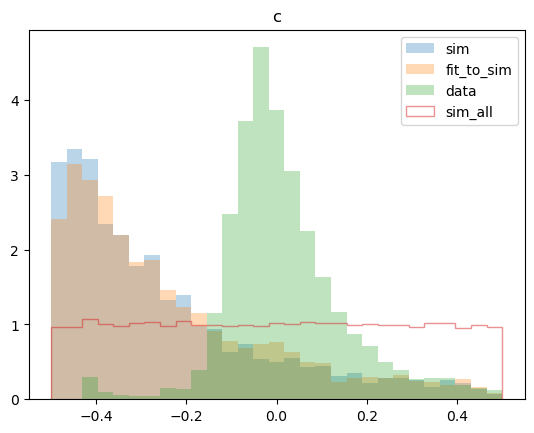

In [34]:
bins=np.linspace(-0.5,0.5,30)
plt.hist(sim_c,bins=bins,alpha=0.3,density=True,label='sim')
plt.hist(c,bins=bins,alpha=0.3,density=True,label='fit_to_sim')
plt.hist(data.c,bins=bins,alpha=0.3,density=True,label='data')
plt.hist(sim_all_c,bins=bins,alpha=0.5,density=True,label='sim_all',histtype='step')
plt.legend()
plt.title('c')

Text(0.5, 1.0, 'host mass')

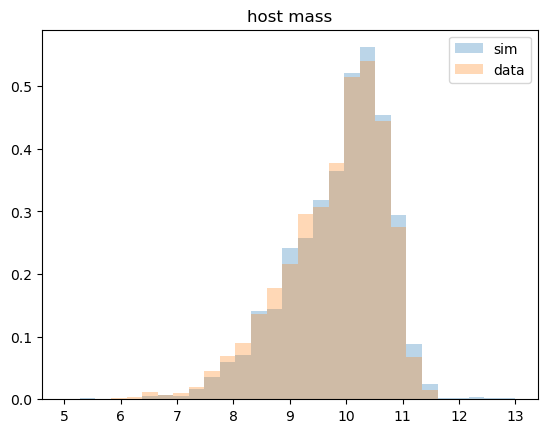

In [35]:
hostmass = [lc_to_fit.loc[i]['params']['host.hostmass'] for i in result_df.index]
bins = np.linspace(5,13,30)
plt.hist(hostmass,bins=bins,alpha=0.3,density=True,label='sim')
plt.hist(data.mass,bins=bins,alpha=0.3,density=True,label='data')
plt.legend()
plt.title('host mass')

657


Text(0.5, 1.0, 'x1 vs host')

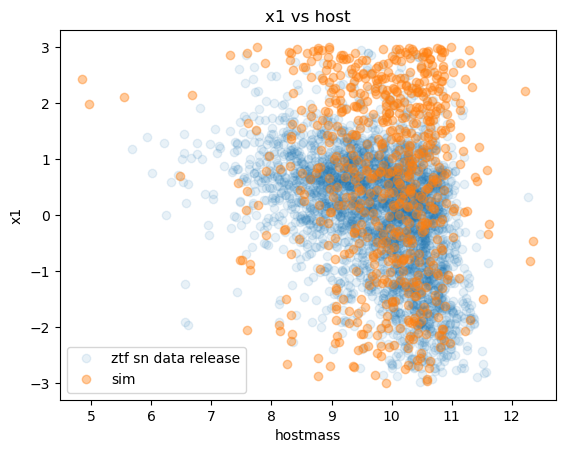

In [36]:
idx = np.array((x1 > -3.) & (x1 < 3.) & (c > -0.3) & (c < 0.3))
data_idx = np.array((data.x1 > -3.) & (data.x1 < 3.) & (data.c > -0.3) & (data.c < 0.3))
print(np.sum(idx))
plt.plot(data[data_idx].mass,data[data_idx].x1,'o',label='ztf sn data release',alpha=0.1)
plt.plot(np.array(hostmass)[idx],np.array(x1)[idx],'o',label='sim',alpha=0.4)
plt.xlabel('hostmass')
plt.ylabel('x1')
plt.legend()
plt.title('x1 vs host')